### Install and import packages

In [16]:
# Import packages
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic
from pypolyagamma import PyPolyaGamma

from utils import *

### Set parameters

In [35]:
# Set parameters
# data_x parameters
num_data = 2
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# weights prior distribution parameters
weights_prior_params = [[0.0, 0.0], [[50.0, 0.0], [0.0, 50.0]]]

pg_burnin_steps = 200

### Generate data_x

In [18]:
# Generate data_x
# data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
data_x = np.array([[0, 1], [1, 0]])
print(data_x)
print(data_x.shape)

[[0 1]
 [1 0]]
(2, 2)


### PolyaGamma Inference function

In [50]:
def gibb_sample_polyagamma(X, y, pg_dist, weights_prior_params, burnin_steps):
    #
    num_data, num_feats = X.shape

    # Gibbs sampling with PG augmentation for burnin_steps
    # init params for gibb sampling are set to be the same as params of prior
    beta_mu = np.array(weights_prior_params[0])
    beta_cov = np.array(weights_prior_params[1])
    beta_hat = np.random.multivariate_normal(beta_mu, beta_cov)
    k = y - 1/2

    # pg = PyPolyaGamma(seed=0)
    # perform Gibbs sampling
    for bid in range(burnin_steps+1):
        # ω ~ PG(b, c) = PG(1, x*β).
        omega_b = np.ones(num_data)
        omega_c = X @ beta_hat
        omega_diag = np.array(
            [pg_dist.pgdraw(b, c) for b, c in zip(omega_b, omega_c)])

        # β ~ N(m, V).
        V = np.linalg.inv(X.T @ np.diag(omega_diag) @ X + np.linalg.inv(beta_cov))
        m = np.dot(V, X.T @ k + np.linalg.inv(beta_cov) @ beta_mu)
        beta_hat = np.random.multivariate_normal(m, V)

    return beta_hat


### Generate prior and posterior samples

In [51]:
### Generate prior and posterior samples
np.random.seed(1)

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)

pg_dist = PyPolyaGamma(seed=0)

samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
for i in range(num_samples):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(data_x.shape)
    # print(sample_a_y.shape)
    
    # sample weights' posterior from polyagamma inference
    sample_a_weights_posterior = gibb_sample_polyagamma(
        data_x, sample_a_y.squeeze(-1), pg_dist, weights_prior_params, burnin_steps=pg_burnin_steps)
    samples_a_weights_posterior.append(sample_a_weights_posterior)    

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(1000, 2)


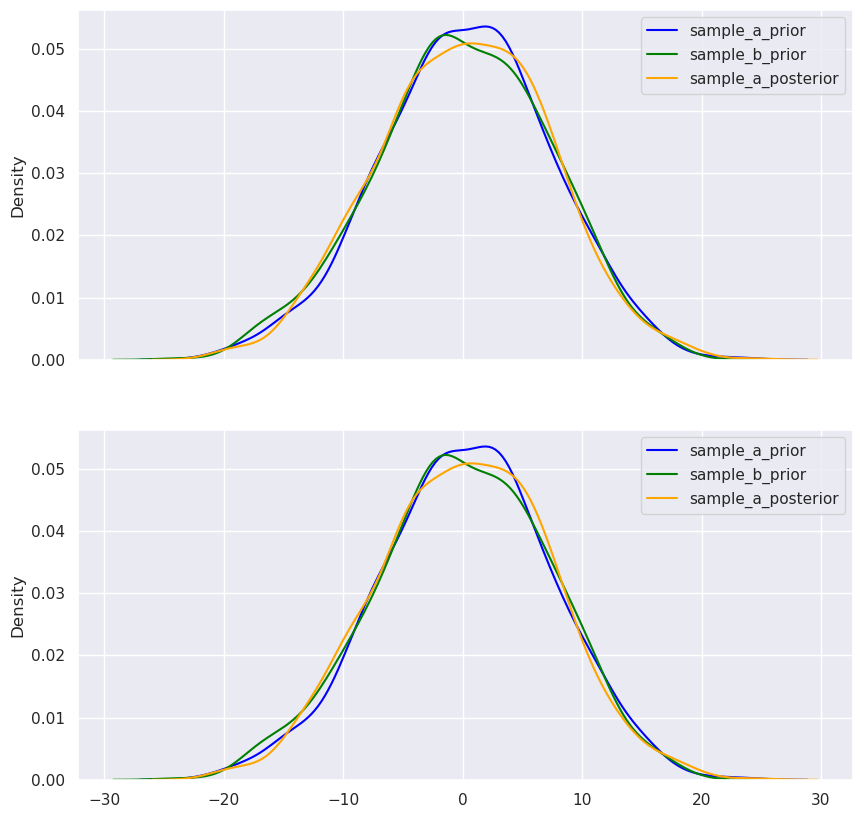

In [52]:
# Visualize the generated prior and posterior samples 
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,0], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,0], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

In [8]:
# # Visualize the generated prior and posterior samples 
# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
# axes = axes.flatten()

# sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[0])

# sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[1])

# sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[2])
# axes[0].set_title("sample_a_prior")
# axes[1].set_title("sample_b_prior")
# axes[2].set_title("sample_a_posterior")
# plt.show()

### Measure the differences between the prior and samples

* Kernelized two sample test: maximum mean distance with RBF kernel
* Wasserstein distance of two samples
* Difference between the standard deviations (from true mean) of two samples

In [53]:
# Maximum mean distance with RBF kernel
mmd_rbf_prior_a_prior_b = compute_mmd_rbf(samples_a_weights_prior, samples_b_weights_prior)
mmd_rbf_posterior_a_prior_b = compute_mmd_rbf(samples_a_weights_posterior, samples_b_weights_prior)
print(f"MMD between prior a and prior b: {mmd_rbf_prior_a_prior_b:0.5f}")
print(f"MMD between posterior a and prior b: {mmd_rbf_posterior_a_prior_b:0.5f}")

MMD between prior a and prior b: 0.00219
MMD between posterior a and prior b: 0.00190


In [54]:
# Wasserstein distance with RBF kernel
wd_prior_a_prior_b = compute_wasserstein_distance(samples_a_weights_prior, samples_b_weights_prior)
wd_posterior_a_prior_b = compute_wasserstein_distance(samples_a_weights_posterior, samples_b_weights_prior)
print(f"Wasserstein distance between prior a and prior b: {wd_prior_a_prior_b:0.5f}")
print(f"Wasserstein distance between posterior a and prior b: {wd_posterior_a_prior_b:0.5f}")

Wasserstein distance between prior a and prior b: 0.97323
Wasserstein distance between posterior a and prior b: 0.97314


In [55]:
# Difference between the standard deviations (from true mean) of two samples
diff_std_prior_a_prior_b = compute_diff_std(samples_a_weights_prior, samples_b_weights_prior, weights_prior_params[0])
diff_std_posterior_a_prior_b = compute_diff_std(samples_a_weights_posterior, samples_b_weights_prior, weights_prior_params[0])
print(f"Difference standard deviations between between prior a and prior b: {diff_std_prior_a_prior_b:0.5f}")
print(f"Difference standard deviations between posterior a and prior b: {diff_std_posterior_a_prior_b:0.5f}")

Difference standard deviations between between prior a and prior b: 0.05072
Difference standard deviations between posterior a and prior b: 0.07826
